In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
from matplotlib import pyplot as plt, colors, ticker
from tqdm import tqdm_notebook as tqdm
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from itertools import chain
from nltk import NaiveBayesClassifier
from nltk.classify import accuracy
from nltk.metrics.scores import f_measure, precision, recall
import re
import string
import collections
import pickle
pos = open("positive_emoji_v2.csv").read().split(",")
neg = open("negative_emoji_v2.csv").read().split(",")
#print("Positive emoji: {}\n\nNegative emoji: {}\n".format("".join(pos), "".join(neg)))
files = sorted(glob.glob("egypt tweets/egypt_tweets*.csv"))
#print(files)
pd.set_option('display.max_colwidth', -1)

In [2]:
%%time
try:
    train = pd.read_csv("train.csv", sep=";", engine="python")
except:
    train = []
    for f in tqdm(files):
        df = pd.read_csv(f, sep=";")
        feels = np.zeros(len(df), dtype=int)
        for i in tqdm(range(len(df))):
            html = df.html[i]
            if type(html) != str:
                continue
            feel = sum([e in html for e in pos]) - sum([e in html for e in neg])
            feels[i] = feel
        df["feel"] = feels
        train.append(df[df.feel != 0])
    train = pd.concat(train)
    print(len(train))
    text_with_emoji = np.empty(len(train), dtype=object)
    for i, html in enumerate(tqdm(train.html)):
        soup = BeautifulSoup(html, "lxml")
        s = []
        for child in soup.find("p").children:
            if child.name == None:
                s.append(child)
            elif child.name == "img":
                s.append(child["alt"])
            else:
                s.append(child.text)
        text_with_emoji[i] = " ".join(s)
    train.text = text_with_emoji
    train[["text", "feel"]].to_csv("train.csv", sep=";", index=False)

CPU times: user 2.15 s, sys: 114 ms, total: 2.27 s
Wall time: 2.28 s


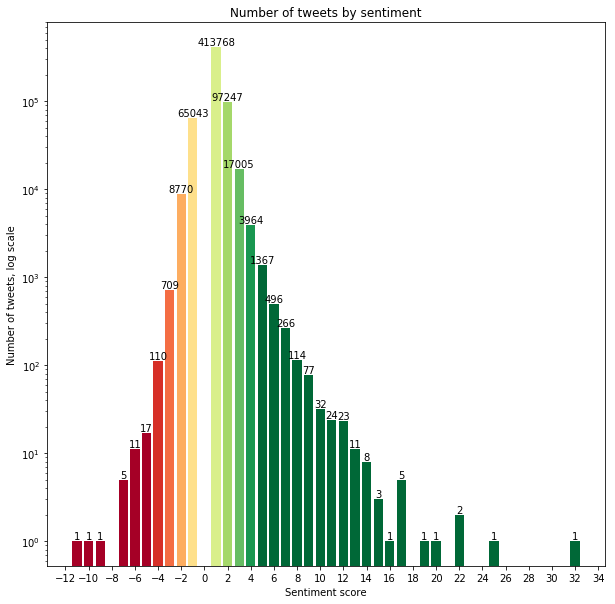

In [3]:
tvc = train.feel.value_counts().sort_index()
values = tvc.values
keys = tvc.keys()

plt.figure(figsize = (10,10))
cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=-5, vmax=5)
plt.bar(keys, values, color=cmap(norm(keys)))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.gca().set_yscale('log')
plt.title("Number of tweets by sentiment")
plt.ylabel("Number of tweets, log scale")
plt.xlabel("Sentiment score")

for i, v in enumerate(values):
    k = keys[i]
    plt.text(k, v, v, ha="center", va="bottom")

In [4]:
word_frequencies = {}
for tweet in tqdm(train.text):
    for word in tweet.split():
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

words_by_popularity = sorted(word_frequencies.items(), key=lambda kv: kv[1], reverse=True)
word_frequencies = pd.DataFrame(words_by_popularity, columns=["Word", "Count"])
display(word_frequencies.head(20))

,Word,Count
0,😂,636243
1,…,99283
2,❤,66171
3,❤️,63859
4,و,57607
5,من,56550
6,يا,53606
7,♥️,48580
8,انا,48154
9,😍,44950


In [74]:
vocab = set(word_frequencies[word_frequencies.Count > 100].Word) - set(pos) - set(neg)
print(len(vocab))
train_feat = []
for i in tqdm(range(50000)):
    tweet = train.text[i]
    label = "pos" if train.feel[i] > 0 else "neg"
    words = tweet.split()
    train_feat.append(({word: word in words for word in vocab}, label))
np.random.shuffle(train_feat)
print(len(train_feat))

5018


50000


In [75]:
i = int(len(train_feat) * .25)
xtrain = train_feat[i:]
xtest = train_feat[:i]
print(len(xtrain), len(xtest))

37500 12500


In [76]:
%%time
classifier = nltk.NaiveBayesClassifier.train(xtrain)
with open('sentiment_classifier_model.pickle', 'wb') as f:
    pickle.dump({
        "vocab": vocab,
        "model": classifier
    }, f)

CPU times: user 3min 20s, sys: 176 ms, total: 3min 20s
Wall time: 3min 20s


In [81]:
classifier.show_most_informative_features()

Most Informative Features
                      :P = True              pos : neg    =     22.3 : 1.0
                       🔫 = True              neg : pos    =     18.8 : 1.0
                  الحنين = True              neg : pos    =     16.9 : 1.0
                    رياض = True              neg : pos    =     16.9 : 1.0
                   قادره = True              neg : pos    =     16.9 : 1.0
                 الشناوي = True              neg : pos    =     16.9 : 1.0
                    بدور = True              neg : pos    =     15.9 : 1.0
                     خرا = True              neg : pos    =     15.9 : 1.0
                  الصداع = True              neg : pos    =     15.5 : 1.0
                   يرحمه = True              neg : pos    =     13.7 : 1.0


In [82]:
print("Accuracy: {}".format(accuracy(classifier, xtest)))

Accuracy: 0.85136


In [86]:
def classify(text):
    words = text.split()
    features = {word: word in words for word in vocab}
    return classifier.classify(features)
for tweet in np.random.choice(train.text, 10, replace=False):
    display(tweet)
    print(classify(tweet))

'لا انا كنت بالش بس  😂'

pos


'Work  💪 💪 👷\u200d♂️  @ Nazlat `Abd Allah, Asyut, Egypt  https://www.instagram.com/ahmedsamiralemam/p/BwIcAgZggDSRKinYhvxRdqrM1Cpv1oFshs0dPQ0/?utm_source=ig_twitter_share&igshid=p9tt8dh09ixz\xa0…'

pos


'امييييين ياااارب  💔'

pos


'قيمي ياشاطره  😂'

pos


'احنا شعب اووووفر شويتين  😂 😂 😂 😂 😂 😂 https://twitter.com/Nardeen_Adeel/status/1118515134345904128\xa0…'

pos


'بيعذبونا عشان اخر سنه  😹 😭 💔'

pos


'أراك متأثر  😂 😂'

pos


'بتشل م كدا جدا\u2066 🤦🏻\u200d♀️ \u2069 😂 \nعشان بضطر امسحها وانزلها تاني 🌝 🌚   https://twitter.com/rashedy_74/status/1146198502571237376\xa0…'

neg


'هههههههههههه يخربيتك بجد  😂 👊🏻'

pos


'😍 💛 💛 🌻 \n @zoozy_273 https://twitter.com/llncai/status/1140616842794479616\xa0…'

pos
